# Analisando e prevendo dados (Acme)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import zscore

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import mlxtend as mlx
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

In [34]:
print("Python", sys.version)
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("SKLearn:", sklearn.__version__)

Python 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
Pandas: 1.2.4
Numpy: 1.22.2
SKLearn: 1.0.2


### **Algumas Funções Necessárias**

In [35]:
def format_data(value):
    if type(value) is np.float64:
        return "{:.4f}".format(value)
    elif type(value) is np.int64:
        return "{:d}".format(value)
    else:
        return "{:s}".format(value)

def normalize_minmaxscaler(df):
    df_norm = df.copy()
    norm_cols = ['demo_age','demo_residence_time','job_employment_time','income_salary','debt_bureau_score']
    for column in norm_cols:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
    return df_norm

def fill_nan_with_new_value(df, target):    
    df[target] = df[target].fillna(-1)
    return df

### **Leitura dos dados**

In [36]:
acme_dict = pd.read_csv('acme_description.csv')
with pd.option_context('display.max_rows', None):  
    display(acme_dict)

,varname,description
0,refdate,Data de referência (forma YYYY-MM-DD)
1,demo_age,Idade
2,demo_gender,Gênero
3,demo_marital_status,Estado civil
4,demo_schooling,Escolaridade
5,demo_residence_time,Tempo de residência
6,demo_residence_kind,Tipo de residência
7,job_formal,Tem emprego formal?
8,job_retired,Aposentado?
9,job_employment_time,Tempo empregado


In [37]:
acme_df = pd.read_csv("sample15k_synth_2022.csv")

In [38]:
acme_df.head()

,refdate,demo_age,demo_gender,demo_marital_status,demo_schooling,demo_residence_time,demo_residence_kind,job_formal,job_retired,job_employment_time,job_kind,job_employment_experience,income_social_benefits,income_salary,debt_profile,debt_prev_history,debt_bureau_score,target
0,2015-08-25,17,-1,1,4,12,1,0,0,19,2,1.0,0,1034.5000,-1,0,NaN,0
1,2015-08-12,25,1,1,4,60,1,1,0,0,2,0.0,0,1344.8500,0,0,0.8218,0
2,2015-08-08,40,1,1,3,98,1,1,0,0,4,0.0,0,2275.9000,2,0,0.9558,1
3,2015-08-14,29,0,1,5,108,1,0,0,30,2,1.0,0,1344.8500,5,0,0.9304,0
4,2015-08-28,19,-1,1,4,120,1,0,0,0,4,0.0,0,1008.6375,-1,0,NaN,0


In [39]:
q_examples = len(acme_df)
q_bad = len(acme_df[acme_df['target'] == 1])
q_good = q_examples - q_bad
print(f""" Neste dataset temos {q_examples} exemplos (dados únicos), dos quais: {q_good} são classificados como 'bons pagadores', e {q_bad} são classificados como 'maus pagadores'.""")

 Neste dataset temos 15000 exemplos (dados únicos), dos quais: 12269 são classificados como 'bons pagadores', e 2731 são classificados como 'maus pagadores'.


### **Analisando dados faltantes**

In [40]:
acme_df.isnull().sum()

refdate                        0
demo_age                       0
demo_gender                    0
demo_marital_status            0
demo_schooling                 0
demo_residence_time            0
demo_residence_kind            0
job_formal                     0
job_retired                    0
job_employment_time            0
job_kind                       0
job_employment_experience      0
income_social_benefits         0
income_salary                  0
debt_profile                   0
debt_prev_history              0
debt_bureau_score            454
target                         0
dtype: int64

In [41]:
acme_df[acme_df['debt_bureau_score'].isna()].demo_age.value_counts().sort_index()

17    109
18     44
19    135
20     54
21     30
22     15
23     10
24      8
25      2
26      1
27      5
28      5
29      2
30      3
31      3
32      1
33      1
35      2
36      4
37      3
38      1
40      2
41      2
42      1
44      1
46      1
48      1
51      1
53      1
54      2
56      1
57      3
Name: demo_age, dtype: int64

In [42]:
acme_df[acme_df['debt_bureau_score'].isna()].debt_profile.value_counts()

-1    215
 0    113
 4     61
 5     41
 2     13
 1      9
 3      2
Name: debt_profile, dtype: int64

In [43]:
acme_df.debt_bureau_score.mean()

0.8449321737934826

In [44]:
acme_df.debt_bureau_score.mode()

0    0.7764
dtype: float64

In [45]:
acme_df.debt_bureau_score.median()

0.8506

**Reflexão em relação aos dados faltantes**

É importante analisar o porquê de um valor ser NaN, antes de tomarmos qualquer decisão em relação ao tratamento desses valores. Como podemos ver na lista anterior, apenas uma coluna possui valores NaN, o que já deve levantar uma suspeita em nós. Por que só essa coluna possui missing values? O que esses missing values representam?

Nem sempre valores faltantes no nosso dataset são gerados devido a algum erro no dataset ou na extração daqueles dados, em alguns casos os missing values também são fontes de informação, e antes de inserirmos qualquer valor nesses espaços vazios, é preciso saber o que devemos inserir neles.

Em casos que os valores faltantes são devido a algum evento aleatório, como por exemplo a perda desses dados em alguma transferência de dados, devemos buscar alguma forma de preencher esses valores baseado nas informações que o restante do dataset nos oferece. Podemos utilizar: moda, média, mediana ou mesmo uma regressão linear dos valores para que um valor mais preciso seja dado para aqueles pontos. Essa estratégia se chama estimação de valor ausente (inputation).

Porém, se imaginarmos agora que há um formulário para alunos de faculdade e nesse formulário é necessário que a pessoa insira o número da CNH dela, e com o resultado da pesquisa seja gerado um DataFrame no Pandas. O que será que acontece quando um determinado aluno não possui a CNH? Exatamente, o campo da CNH daquele aluno será NaN, porque ele não foi preenchido, não por um erro do aluno ou qualquer evento aleatório, mas porque é uma característica de um determinado grupo de alunos não ter CNH. Agora, quais estratégias poderíamos utilizar parar retirar esse números NaN? Será que preencher esse espaço com a média, moda ou mediana dos números de CNH seria interessante? Caso façamos isso, estaríamos tirando uma característica interessante de um determinado grupo de alunos.

E é exatamente isso que está acontecendo nesse dataset. O campo que possui valores faltantes é o Score de crédito daquela determinada pessoa no mercado. Porém, e se aquela pessoa não possuir nenhum Score no mercado? Não tiver nenhuma conta em banco? Nunca tiver tido um cartão de crédito? O Score dela será desconhecido, logo, será NaN em nosso dataset. E é isso que é falado no PDF com a tabela dos dados: "Escore de crédito no mercado (NaN = desconhecido)".

Se olharmos com atenção pro grupo de pessoas que possuem os dados NaN, são em geral pessoas mais novas, com menos de 20 anos, que provavelmente nunca tiveram seu Score gerado pelo mercado financeiro, e ter o seu Score desconhecido também é uma característica que deve ser avaliada pelo modelo. Ao utilizarmos a média como input para os missing values, acabamos perdendo essa informação super importante. Então, qual seria uma boa estratégia? Em geral, para missing values que são importantes pro modelo reconhecer um determinado grupo de pessoas, utilizamos um número que está fora do range natural daquela variável. Por exemplo, o range do score de mercado vai de 0 a 1000, então podemos utilizar como valor de input para os missing values o -1, por exemplo, ou o 9999. Isso vai fazer com que o modelo consiga entender que o Score daquelas pessoas é desconhecido e que existe informação dentro disso. Nesse modelo, vou substituir os valores NaN por -1.

### **Analisando os dados**

Como primeiro gráfico, vou olhar a distribuição das classes, ou seja, quantas amostras temos de cada um dos dois tipos de pagadores (bom e ruim).

<AxesSubplot:xlabel='target', ylabel='count'>

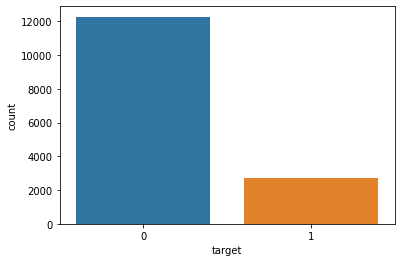

In [46]:
sns.countplot(acme_df['target'])

Agora quero ver qual a correlação entre cada par de atributo numérico do dataset:

<AxesSubplot:title={'center':'Correlation heatmap matrix'}>

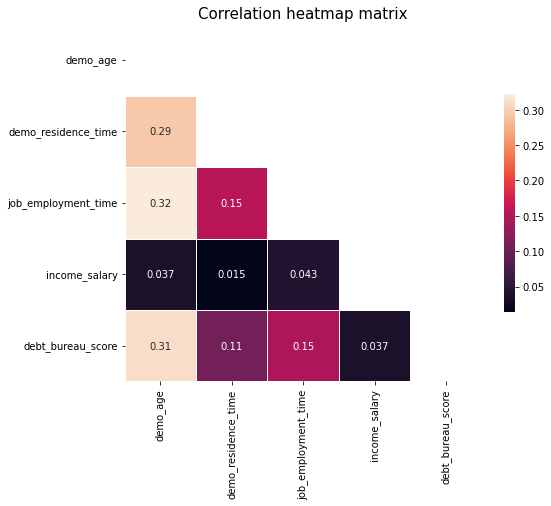

In [47]:
correlation_matrix = acme_df[['demo_age', 'demo_residence_time', 'job_employment_time', 'income_salary', 'debt_bureau_score']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
%matplotlib inline
plt.figure(figsize=(8,8))
plt.title("Correlation heatmap matrix", fontsize=15)
sns.heatmap(correlation_matrix, mask=mask,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A matriz de correlação acima mostrou que há uma correlação média positiva. As maiores correlações em ordem descrecente são entre os atributos:

1. "idade" e "tempo empregado"
2. "idade" e "escore de credito no mercado"
4. "idade" e "tempo de residência"
5. "escore de credito no mercado" e "tempo empregado"

No gráfico abaixo, a correlação é diferente entre os clientes classificados como bons e maus pagadores. Podemos perceber que temos mais bons pagadores como pessoas que tem mais idade e que trabalham/trabalharam por mais tempo. Isso nos traz uma boa informação em relação a essas variáveis.

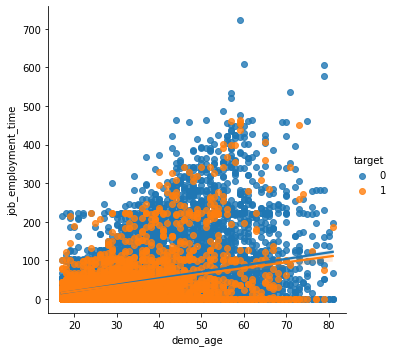

In [48]:
sns.lmplot(x="demo_age", y="job_employment_time", hue="target", data=acme_df)

No gráfico abaixo, a correlação é semelhante entre os clientes classificados como bons e maus pagadores. 

Podemos perceber que há uma grande concentração entre clientes que são bons e maus pagadores com um score de crédito positivo.

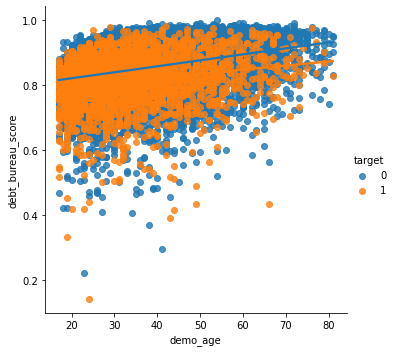

In [49]:
sns.lmplot(x="demo_age", y="debt_bureau_score", hue="target", data=acme_df)

No gráfico abaixo, a correlação é mais ou menos semelhante entre os clientes classificados como bons e maus pagadores, com minimos casos que podemos considerar, talvez, como outliers. 

Podemos perceber que temos mais bons pagadores como pessoas que tem mais idade e que tem mais tempo de residencia. E maus pagadores pessoas com menos idade e menos tempo de residência.

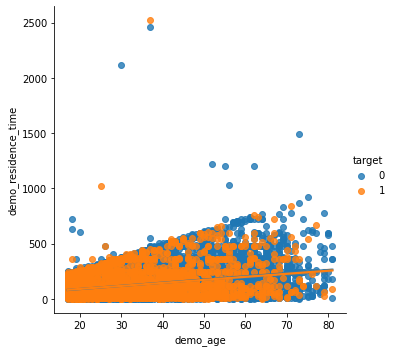

In [50]:
sns.lmplot(x="demo_age", y="demo_residence_time", hue="target", data=acme_df)

No gráfico abaixo, há uma grande concentração entre clientes que são bons e maus pagadores com scores positivos, no entanto temos mais bons pagadores que apresentam mais tempo de trabalho e com scores mais altos.

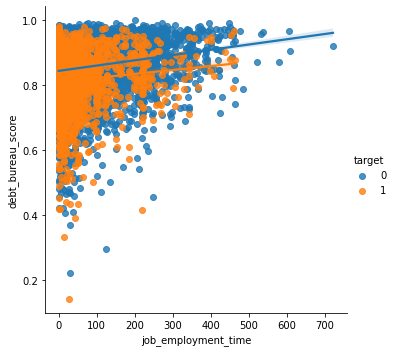

In [51]:
sns.lmplot(x="job_employment_time", y="debt_bureau_score", hue="target", data=acme_df)

A distribuição de frequências dos atributos 'salario', 'idade' e 'score de credito':

No primeiro gráfico, podemos notar que 100.0% dos valores são abaixo de 100000;
No segundo gráfico, podemos notar que 98.7% dos clientes possui menos de 70 anos;
No terceiro gráfico, podemos notar que 23.4% dos clientes possui menos de 0.8 de score;


<AxesSubplot:xlabel='debt_bureau_score'>

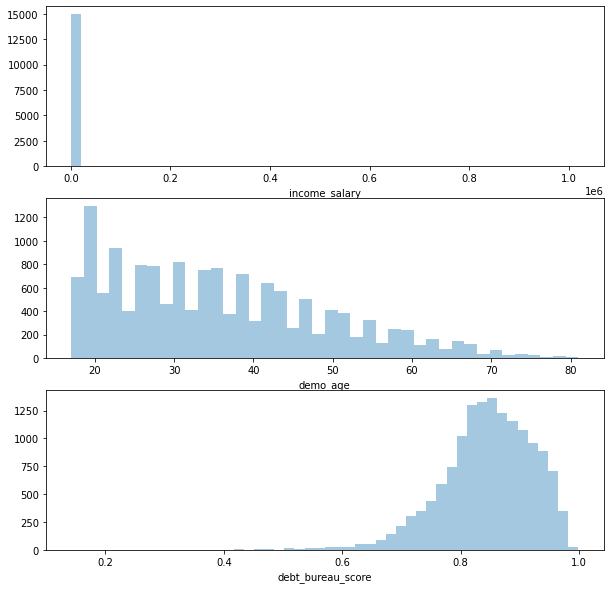

In [52]:
perc_salary  = (len(acme_df[acme_df['income_salary'] < 100000]) / q_examples) * 100
perc_age = (len(acme_df[acme_df['demo_age'] < 70]) / q_examples) * 100
perc_score = (len(acme_df[acme_df['debt_bureau_score'] < .8]) / q_examples) * 100

print(f"""No primeiro gráfico, podemos notar que {perc_salary:.1f}% dos valores são abaixo de 100000;
No segundo gráfico, podemos notar que {perc_age:.1f}% dos clientes possui menos de 70 anos;
No terceiro gráfico, podemos notar que {perc_score:.1f}% dos clientes possui menos de 0.8 de score;""")

%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplot(311)
sns.distplot(acme_df['income_salary'],kde=False)
plt.subplot(312)
sns.distplot(acme_df['demo_age'],kde=False)
plt.subplot(313)
sns.distplot(acme_df['debt_bureau_score'],kde=False)

Compara diretamente a distribuição entre os bons e maus pagadores para "estado civil" e "sexo": 

<AxesSubplot:xlabel='demo_marital_status', ylabel='demo_age'>

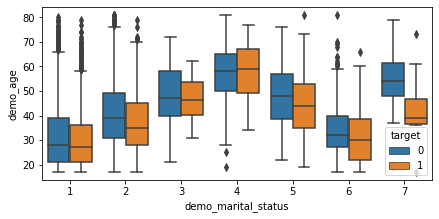

In [53]:
plt.figure(figsize=(7,7))
plt.subplot(211)
sns.boxplot(x="demo_marital_status", y="demo_age", hue="target",data=acme_df)

Compara a distribuição entre os diferentes grupos de "estado civil" e "idade" para bons e maus pagadores:

<AxesSubplot:xlabel='target', ylabel='demo_age'>

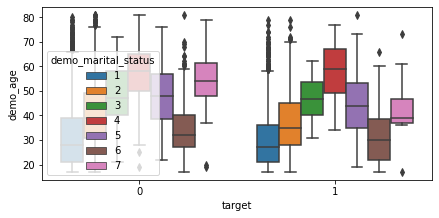

In [54]:
plt.figure(figsize=(7,7))
plt.subplot(211)
sns.boxplot(x="target", y="demo_age", hue="demo_marital_status",data=acme_df)

Compara a distribuição entre os diferentes grupos de "idade" e "genero" para bons e maus pagadores:

<AxesSubplot:xlabel='target', ylabel='demo_age'>

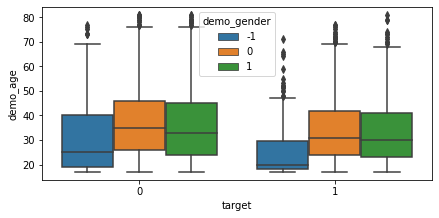

In [55]:
plt.figure(figsize=(7,7))
plt.subplot(211)
sns.boxplot(x="target", y="demo_age", hue="demo_gender",data=acme_df)

### Verificando a existência de outliers nos dados, a seguir:

Adiciona o eixo Y em escala logarítimica para melhor visualização dos dados:

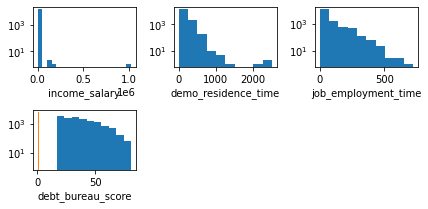

In [56]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.hist(acme_df['income_salary'], bins=20)
plt.yscale('log')
plt.xlabel('income_salary')

plt.subplot(3, 3, 2)
plt.hist(acme_df['demo_residence_time'])
plt.yscale('log')
plt.xlabel('demo_residence_time')

plt.subplot(3, 3, 3)
plt.hist(acme_df['job_employment_time'])
plt.yscale('log')
plt.xlabel('job_employment_time')

plt.subplot(3, 3, 4)
plt.hist(acme_df['demo_age'])
plt.yscale('log')
plt.xlabel('demo_age')

plt.subplot(3, 3, 4)
plt.hist(acme_df['debt_bureau_score'])
plt.yscale('log')
plt.xlabel('debt_bureau_score')

#espaçamento entre os subplots
fig.tight_layout()

plt.show()

### Análise boxplot (quartis):

Adiciona o eixo Y em escala logarítimica para melhor visualização dos dados:

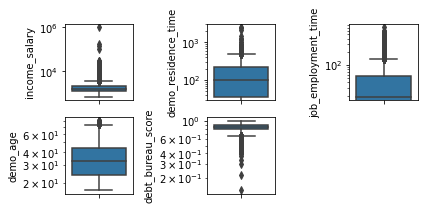

In [57]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.boxplot(y=acme_df['income_salary'])
plt.yscale('log')

plt.subplot(3, 3, 2)
sns.boxplot(y=acme_df['demo_residence_time'])
plt.yscale('log')

plt.subplot(3, 3, 3)
sns.boxplot(y=acme_df['job_employment_time'])
plt.yscale('log')

plt.subplot(3, 3, 4)
sns.boxplot(y=acme_df['demo_age'])
plt.yscale('log')

plt.subplot(3, 3, 5)
sns.boxplot(y=acme_df['debt_bureau_score'])
plt.yscale('log')

fig.tight_layout()
plt.show()

Remolve os outliers baseado nas distribuições entre os quartis (IQR):

In [58]:
Q1 = acme_df['income_salary'].quantile(0.25)
Q3 = acme_df['income_salary'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = acme_df[~((acme_df['income_salary']< (Q1 - 1.5 * IQR)) |(acme_df['income_salary']> (Q3 + 1.5 * IQR)))]

Q1 = acme_df['demo_residence_time'].quantile(0.25)
Q3 = acme_df['demo_residence_time'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['demo_residence_time']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['demo_residence_time']> (Q3 + 1.5 * IQR)))]

Q1 = acme_df['job_employment_time'].quantile(0.25)
Q3 = acme_df['job_employment_time'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['job_employment_time']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['job_employment_time']> (Q3 + 1.5 * IQR)))]

Q1 = acme_df['debt_bureau_score'].quantile(0.25)
Q3 = acme_df['debt_bureau_score'].quantile(0.75)
IQR = Q3 - Q1
df_sem_outliers = df_sem_outliers[~((df_sem_outliers['debt_bureau_score']< (Q1 - 1.5 * IQR)) |(df_sem_outliers['debt_bureau_score']> (Q3 + 1.5 * IQR)))]

a = (1 - len(df_sem_outliers)/len(acme_df))*100
print(f'Porcentagem de outliers removidos: {round(a, 2)}%' )

Porcentagem de outliers removidos: 18.55%


Dados sem outliers, visualização dos dados:

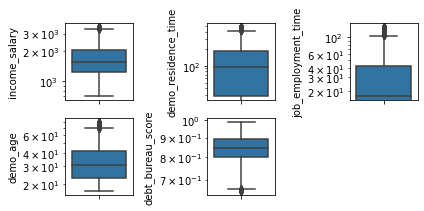

In [59]:
fig = plt.figure()

plt.subplot(3, 3, 1)
sns.boxplot(y=df_sem_outliers['income_salary'])
plt.yscale('log')

plt.subplot(3, 3, 2)
sns.boxplot(y=df_sem_outliers['demo_residence_time'])
plt.yscale('log')

plt.subplot(3, 3, 3)
sns.boxplot(y=df_sem_outliers['job_employment_time'])
plt.yscale('log')

plt.subplot(3, 3, 4)
sns.boxplot(y=df_sem_outliers['demo_age'])
plt.yscale('log')

plt.subplot(3, 3, 5)
sns.boxplot(y=df_sem_outliers['debt_bureau_score'])
plt.yscale('log')

fig.tight_layout()
plt.show()

Resolvi limpar os outliers dos dados acima por serem os que mais tem dispersão de valores.


### Fit das distribuições:

* importante para entender quais variáveis são potenciais para serem utilizadas no modelo.

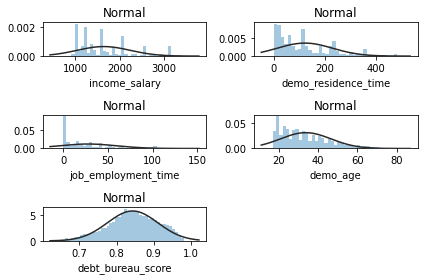

In [60]:
fig = plt.figure()

plt.subplot(3, 2, 1)
y = df_sem_outliers['income_salary']
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('income_salary')

plt.subplot(3, 2, 2)
plt.title('Normal')
y = df_sem_outliers['demo_residence_time']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('demo_residence_time')

plt.subplot(3, 2, 3)
plt.title('Normal')
y = df_sem_outliers['job_employment_time']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('job_employment_time')

plt.subplot(3, 2, 4)
plt.title('Normal')
y = df_sem_outliers['demo_age']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('demo_age')

plt.subplot(3, 2, 5)
plt.title('Normal')
y = df_sem_outliers['debt_bureau_score']
sns.distplot(y, kde=False, fit=st.norm)
plt.xlabel('debt_bureau_score')


# set the spacing between subplots
fig.tight_layout()

plt.show()

Todas as variaveis parecem se adaptar bem as distribuições, sendo assim vou manter todas elas na classificação.

Agora quero ver qual a correlação entre cada par de atributo numérico do dataset (depois de retirar os outliers):

<AxesSubplot:title={'center':'Correlation heatmap matrix'}>

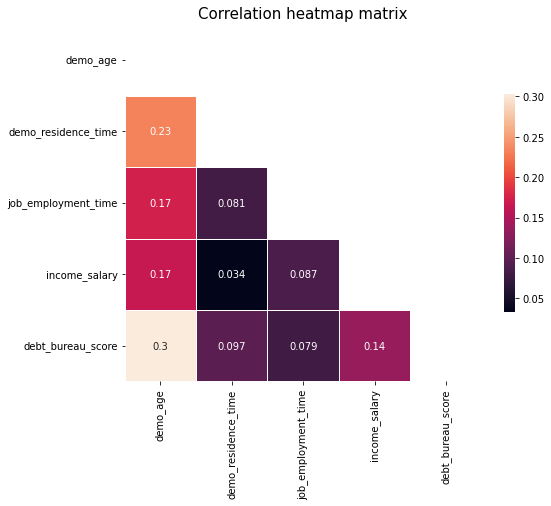

In [61]:
correlation_matrix = df_sem_outliers[['demo_age', 'demo_residence_time', 'job_employment_time', 'income_salary', 'debt_bureau_score']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
%matplotlib inline
plt.figure(figsize=(8,8))
plt.title("Correlation heatmap matrix", fontsize=15)
sns.heatmap(correlation_matrix, mask=mask,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A matriz de correlação acima mostrou que há uma correlação média positiva. As maiores correlações em ordem descrecente são entre os atributos:

1. "idade" e "score de credito no mercado"
2. "idade" e "tempo de residencia"
3. "idade" e "tempo empregado"
4. "idade" e "salario"
5. "escore de credito no mercado" e "salario"

Ou seja, vemos que houve uma mudança nas correlações entre as variáveis.

### Analise dos dados categoricos:

<AxesSubplot:xlabel='debt_prev_history'>

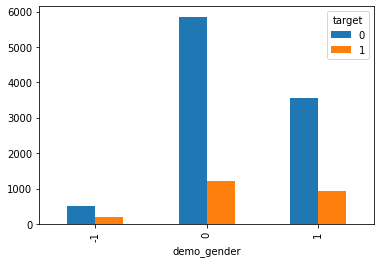

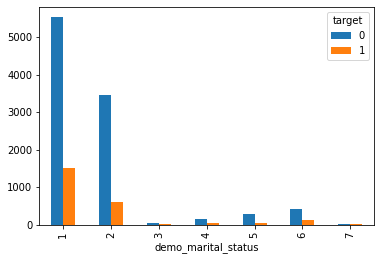

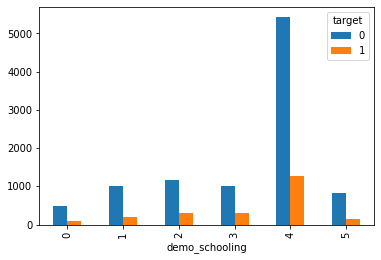

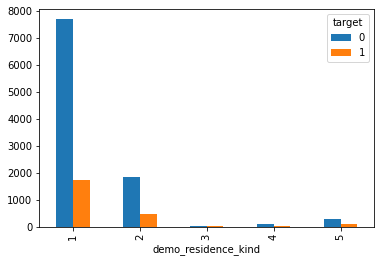

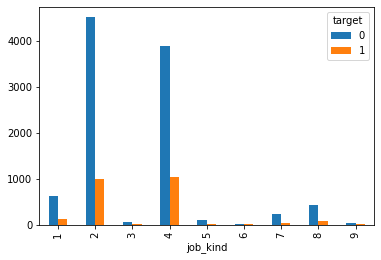

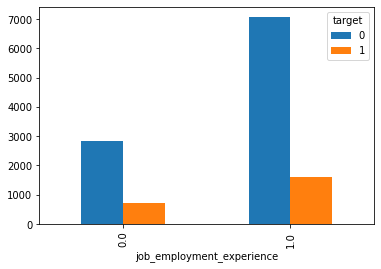

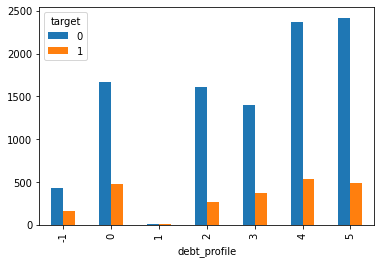

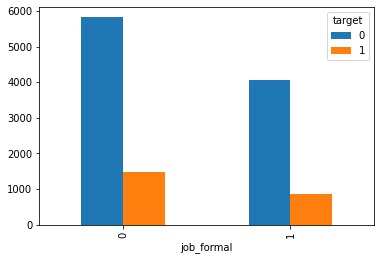

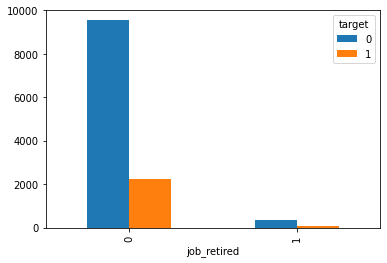

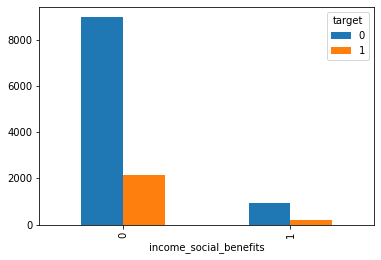

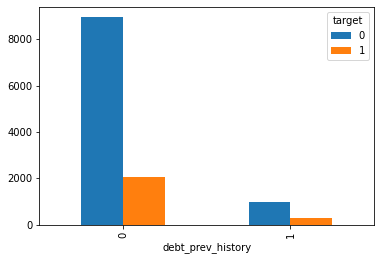

In [62]:
pd.crosstab(df_sem_outliers.demo_gender, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.demo_marital_status, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.demo_schooling, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.demo_residence_kind, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.job_kind, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.job_employment_experience, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.debt_profile, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.job_formal, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.job_retired, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.income_social_benefits, acme_df.target).plot.bar()
pd.crosstab(df_sem_outliers.debt_prev_history, acme_df.target).plot.bar()

### **Reflexões referentes a análise:**

* Existe um grande desbalanceamento nos dados, em relação a quantidade de bons e maus pagadores. Observa-se que há muito mais bons pagadores do que maus pagadores. Isso pode afetar a previsão do algoritmo, pois  faz com que tenhamos muitas informações a respeito das classes mais incidentes, e menos das minoritárias (Paradoxo da Acurácia).

* Resolvir retirar as variáveis de gênero, nível de escolaridade, tempo de experiencia, timpo de residencia e tipo de emprego devido ao seu potencial de criação de viéses indesejados (caráter social) (no entanto, é válido que isso seja discutido).

### **Tratando os dados e separando em treino e teste**

In [63]:
acme_df = df_sem_outliers.drop(['demo_gender',
                      'demo_schooling',
                      'job_employment_experience',
                      'demo_residence_kind',
                      'job_kind'],axis=1)

#Adiciono para os dados ausentes da variavel de score de credito no mercado o valor -1 (Resolvi adicionei aqui, pois percebi que ficariam Nan depois que eu fizesse o QRI)
acme_df = fill_nan_with_new_value(acme_df, ['debt_bureau_score'])

acme_df = acme_df.dropna()

In [64]:
columns = [c for c in acme_df.columns if c != 'target' and c != 'refdate'] 

In [65]:
datas_august = acme_df[acme_df['refdate']<='2015-08-31']
datas_september = acme_df[acme_df['refdate']>'2015-08-31']

In [66]:
train = datas_august
test = datas_september

In [67]:
X_train = train[columns]
y_train = train['target']

In [68]:
X_test = test[columns]
y_test = test['target']

In [69]:
X_train = normalize_minmaxscaler(X_train)
X_test = normalize_minmaxscaler(X_test)

### Balanceando os dados

Como os dados estão desbalanceados, resolvi aplicar a técnica SMOT (Synthetic Minority Oversampling Technique) onde vou aumentar o número de entradas na amostra para que a proporção de bons e maus pagadores para análise de crétido seja equivalente. Dessa forma nossos dados estarão balanceados.

In [70]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test = sm.fit_resample(X_test, y_test)

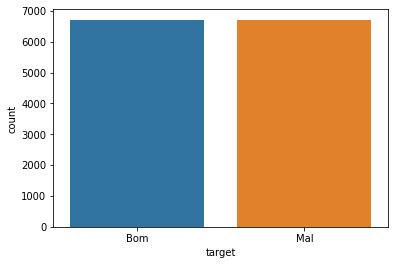

In [71]:
g = sns.countplot(y_train)
g.set_xticklabels(['Bom','Mal'])
plt.show()

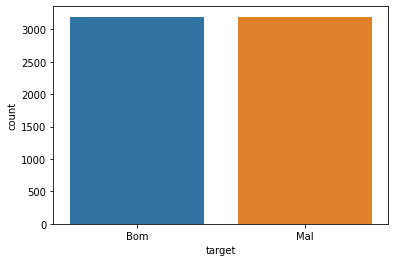

In [72]:
g = sns.countplot(y_test)
g.set_xticklabels(['Bom','Mal'])
plt.show()

### **Treinando o modelo**

* Em conjuntos de dados pequenos, o algortimo RandomForestClassifier consegue classificar os dados bem e ainda evitar overfiting. No entanto, nosso conjunto de dados está desbalanceado, logo será necessário fazer um ajuste na porcetagens entre as classes. Resolvi verificar primeiro sem ajuste e depois com ajudes.

In [73]:
def random_forest_classifier(X_train, y_train, X_test, y_test):
    
    forest = RandomForestClassifier(n_estimators=100, random_state=1)
    model_forest = forest.fit(X_train, y_train) 
    
    y_pred = model_forest.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    acuracy = round(accuracy_score(y_test,y_pred),3)*100
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    cr = classification_report(y_test, y_pred, target_names=["Good", "Bad"])
    
    return acuracy, recall, precision, roc_auc, cm, cr, model_forest, y_pred

def gradient_boosting_classifier(X_train, y_train, X_test, y_test):
    
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=1)
    model = gbc.fit(X_train, np.ravel(y_train, order='C'))
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    acuracy = round(accuracy_score(y_test,y_pred),3)*100
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    cr = classification_report(y_test, y_pred, target_names=["Good", "Bad"])
    
    return acuracy, recall, precision, roc_auc, cm, cr, model, y_pred

* Para verificar os resultados, a matriz de confusão é usada e percebemos que o algoritmo classificou a maioria das pessoas como bons pagadores e era previsto que isso acontecesse, já que a diferença de quantidade das classificações é muito grande.
* Uma das formas de contornar esse problema é diminuindo a quantidade de observações com maior número de classificação, afim de equalizar.

#### **RandomForestClassifier**

In [74]:
acuracy_rf, recall_rf, precision_rf, roc_auc_rf, cm_rf, cr_rf, model_rf, prev_rf = random_forest_classifier(X_train, y_train, X_test, y_test)

____ Random Forest Regressor____



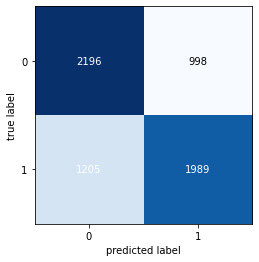

Random Forest recall: 0.6227301189730745
Random Forest AUC: 0.6551

Random Forest precision: 0.6658855038500168
Random Forest accuracy:  65.5 %
              precision    recall  f1-score   support

        Good       0.65      0.69      0.67      3194
         Bad       0.67      0.62      0.64      3194

    accuracy                           0.66      6388
   macro avg       0.66      0.66      0.65      6388
weighted avg       0.66      0.66      0.65      6388



In [75]:
print("____ Random Forest Regressor____\n")

fig, ax = plot_confusion_matrix(conf_mat=cm_rf)
plt.show()

print('Random Forest recall:', recall_rf)
print("Random Forest AUC: {:.4f}\n".format(roc_auc_rf))
print('Random Forest precision:', precision_rf)
print(f"Random Forest accuracy:  {acuracy_rf} %")
print(cr_rf)

* Apesar da baixa acurácia, houve um aumento significativo na capacidade do modelo em detectar se uma pessoa é um pagador ruim. Melhora significativa em parâmetros como recall e na área sob a curva (AUC), que são métricas extremamente importantes para o problema que estamos lidando.

* Como o objetivo maior desta análise é encontrar os maus pagadores, para que diminua a chance de inadimplência preciso observar os resultados da classe "Bad" e vamos dar prioridade para a métrica "recall". 

* O "recall" é utilizado quando o custo de um falso negativo (identificado como bom pagador, mas que é mau pagador) pode gerar grandes problemas, que é o nosso caso.

#### Grau de Importância com RandomForestClassifier

In [76]:
acme_imp = dict(zip(list(acme_dict['varname'].values), list(acme_dict['description'].values)))

In [77]:
dt = pd.DataFrame({'COLUM': columns, 'IMPORTANCE': model_rf.feature_importances_}).sort_values('IMPORTANCE', ascending = False)
dt['INDEX'] = 1 + np.array(range(dt.shape[0])).reshape(-1,1)
dt['DESCRIPTION'] = dt['COLUM'].apply(lambda v: acme_imp[v])
dt.set_index('COLUM', inplace = True)
dt[['DESCRIPTION', 'INDEX', 'IMPORTANCE']].style.format(format_data).background_gradient(cmap = 'PuBu')

,DESCRIPTION,INDEX,IMPORTANCE
COLUM,,,
debt_bureau_score,Escore de crédito no mercado (NaN = desconhecido),1,0.2111
demo_residence_time,Tempo de residência,2,0.1672
demo_age,Idade,3,0.1670
income_salary,Salário declarado,4,0.1655
job_employment_time,Tempo empregado,5,0.1423
debt_profile,Perfil como pagador,6,0.0627
demo_marital_status,Estado civil,7,0.0337
job_formal,Tem emprego formal?,8,0.0219
debt_prev_history,Já foi mau pagador no mercado?,9,0.0128


#### **Gradient Boosting (GBM)** 

* Tentei escolher um algoritmo mais resistente para tentar verificar se haveria uma melhora no recall.

In [78]:
acuracy, recall, precision, roc_auc, cm, cr, model, prev = gradient_boosting_classifier(X_train, y_train, X_test, y_test)

____ Gradient Boosting ____



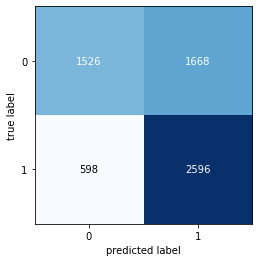

Gradient Boosting recall: 0.812773951158422
Gradient Boosting AUC: 0.6453

Gradient Boosting  precision: 0.6088180112570356
Gradient Boosting accuracy:  64.5 %
              precision    recall  f1-score   support

        Good       0.72      0.48      0.57      3194
         Bad       0.61      0.81      0.70      3194

    accuracy                           0.65      6388
   macro avg       0.66      0.65      0.64      6388
weighted avg       0.66      0.65      0.64      6388



In [79]:
print("____ Gradient Boosting ____\n")

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

print('Gradient Boosting recall:', recall)
print("Gradient Boosting AUC: {:.4f}\n".format(roc_auc))
print('Gradient Boosting  precision:', precision)
print(f"Gradient Boosting accuracy:  {acuracy} %")
print (cr)

* Percebe-se que o algoritmo acertou agora mais pagadores ruins do que bons pagadores;
* No entanto, poder ser eficiente para uma classe mas não para outra.

#### Grau de Importância Gradient Boosting (GBM)

In [80]:
acme_imp = dict(zip(list(acme_dict['varname'].values), list(acme_dict['description'].values)))

In [81]:
dt = pd.DataFrame({'COLUM': columns, 'IMPORTANCE': model.feature_importances_}).sort_values('IMPORTANCE', ascending = False)
dt['INDEX'] = 1 + np.array(range(dt.shape[0])).reshape(-1,1)
dt['DESCRIPTION'] = dt['COLUM'].apply(lambda v: acme_imp[v])
dt.set_index('COLUM', inplace = True)
dt[['DESCRIPTION', 'INDEX', 'IMPORTANCE']].style.format(format_data).background_gradient(cmap = 'PuBu')

,DESCRIPTION,INDEX,IMPORTANCE
COLUM,,,
debt_bureau_score,Escore de crédito no mercado (NaN = desconhecido),1,0.3748
income_salary,Salário declarado,2,0.3075
job_employment_time,Tempo empregado,3,0.1050
demo_residence_time,Tempo de residência,4,0.0909
demo_age,Idade,5,0.0785
job_formal,Tem emprego formal?,6,0.0169
demo_marital_status,Estado civil,7,0.0111
income_social_benefits,Recebe auxílio social?,8,0.0062
debt_prev_history,Já foi mau pagador no mercado?,9,0.0056
